<div style="
    background-color:rgb(210, 230, 255);
    color:rgb(0, 0, 0);
    padding: 10px;
    border-radius: 10px;
    font-weight: bold;">
<h3>Modèle d'apprentissage automatique pour la prédiction d’usage le plus probable d'une friche en France</h3>
<ul>
    <li>Dans le cadre du projet PROFIL : https://github.com/heuzef/cartofriches</li>
    <li>Auteur : Heuzef (https://heuzef.com)</li>
    <li>Juin 2025</li>
    <li>Destiné au CEREMA</li>
    <li>Les données exploitées sont issues data.gouv.fr, respectant le Standard Friches (version 2022 - rev. v2023-12)</li>
</div>

# Import des librairies

In [103]:
!pip install -r requirements.txt

In [104]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2
import re

# Chargement des données

In [105]:
# Chargement des données de data.gouv.fr, la 35ème colonne possède des Dtype mixte, l'option low_memory=False permet de contourner le problème.
# https://www.data.gouv.fr/fr/datasets/sites-references-dans-cartofriches/#/resources
# https://github.com/cnigfr/schema-friches

df_friches = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/74feb3ed-5f9f-4ef8-8fab-b0128d569a99", sep=";", low_memory=False)

print("Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :")
print(f"{df_friches.shape[0]} friches chargées — {df_friches.shape[1]} variables")
print("Pas de doublon detectés")

Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :
28115 friches chargées — 50 variables
Pas de doublon detectés


In [106]:
print("Liste des variables :")
display(df_friches.dtypes)

Liste des variables :


site_id                       object
site_nom                      object
site_type                     object
site_adresse                  object
site_identif_date             object
site_actu_date                object
site_url                      object
site_ademe_url               float64
site_securite                 object
site_occupation               object
site_statut                   object
site_projet_url              float64
site_reconv_annee            float64
site_reconv_type              object
activite_libelle              object
activite_code                 object
activite_fin_annee            object
comm_nom                      object
comm_insee                    object
bati_type                     object
bati_nombre                  float64
bati_surface                 float64
bati_pollution                object
bati_vacance                  object
bati_patrimoine               object
bati_etat                     object
local_ancien_annee           float64
l

# Analyse de la variable cible

In [107]:
print(f"{df_friches['site_reconv_type'].describe().unique()[1]} valeurs dans la variable cible dans les données de data.gouv.fr (CNIG) :")

for item in df_friches['site_reconv_type'].unique() :
    print(item)

display(df_friches['site_reconv_type'].describe())

13 valeurs dans la variable cible dans les données de data.gouv.fr (CNIG) :
nan
habitat
renaturation
équipement public
mixte
autres activités économiques
autre
inconnu
aménagement d'espace public
commerce
panneaux photovoltaiques
�nergie, hors photovoltaique
bureau
industrie


count        2612
unique         13
top       habitat
freq         1100
Name: site_reconv_type, dtype: object

# Isolation des données des friches reconverties

In [108]:
print(f"Le nombre de valeurs manquantes dans la colonne 'site_reconv_type' est : {df_friches['site_reconv_type'].isna().sum()}")
print(f"Nombre de friches reconverties : {df_friches['site_reconv_type'].count()}")

Le nombre de valeurs manquantes dans la colonne 'site_reconv_type' est : 25503
Nombre de friches reconverties : 2612


In [109]:
df_friches_reconv = df_friches.dropna(subset=['site_reconv_type'])
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")

2612 friches chargées — 50 variables


In [110]:
# Supprimer les friches dont la reconversion est 'autre' ou 'inconnu'
for val in ['autre', 'inconnu']:
    df_friches_reconv = df_friches_reconv.drop(df_friches_reconv[df_friches_reconv['site_reconv_type'] == val].index)

# Affichez les résultats
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
print("Variable cible :")
display(df_friches_reconv['site_reconv_type'].value_counts())

2331 friches chargées — 50 variables
Variable cible :


site_reconv_type
habitat                         1100
mixte                            351
autres activités économiques     328
équipement public                215
commerce                          95
renaturation                      69
bureau                            65
aménagement d'espace public       47
industrie                         33
panneaux photovoltaiques          27
�nergie, hors photovoltaique       1
Name: count, dtype: int64

# Nettoyage

1. "site_ademe_url" => 2331 NaNs (100.0%)
2. "site_projet_url" => 2331 NaNs (100.0%)
3. "site_reconv_annee" => 2331 NaNs (100.0%)
4. "bati_surface" => 2331 NaNs (100.0%)
5. "sol_pollution_annee" => 2331 NaNs (100.0%)
6. "sol_pollution_commentaire" => 2331 NaNs (100.0%)
7. "sol_depollution_fiche" => 2331 NaNs (100.0%)
8. "desserte_distance" => 2331 NaNs (100.0%)
9. "desserte_commentaire" => 2331 NaNs (100.0%)
10. "geomsurf" => 2331 NaNs (100.0%)
11. "activite_code" => 2311 NaNs (99.0%)
12. "activite_libelle" => 2260 NaNs (97.0%)
13. "urba_zone_formdomi" => 2012 NaNs (86.0%)
14. "site_url" => 1939 NaNs (83.0%)
15. "source_contact" => 1892 NaNs (81.0%)
16. "site_adresse" => 1849 NaNs (79.0%)
17. "activite_fin_annee" => 1385 NaNs (59.0%)
18. "site_securite" => 1172 NaNs (50.0%)
19. "source_url" => 983 NaNs (42.0%)
20. "local_ancien_annee" => 902 NaNs (39.0%)
21. "local_recent_annee" => 622 NaNs (27.0%)
22. "urba_zone_type" => 254 NaNs (11.0%)
23. "urba_zone_lib" => 254 NaNs (11.0%)
24. "ur

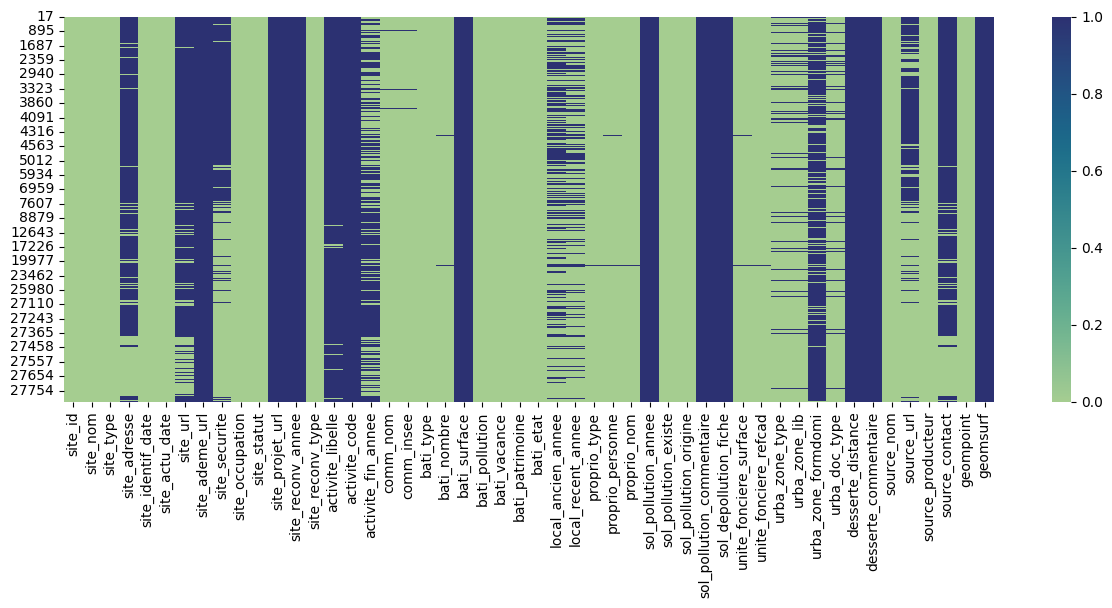

In [111]:
# Fonction de vérification :
def check_nan(df):
    results = []

    for col in df.columns:
        nan_count = df[col].isna().sum()
        nan_percentage = np.round(nan_count * 100 / df.shape[0])
        results.append((col, nan_count, nan_percentage))

    results.sort(key=lambda x: x[2], reverse=True) # Trier les résultats par pourcentage de NaNs

    total_nans = sum(df.isna().sum())

    for line_number, (col, nan_count, nan_percentage) in enumerate(results, start=1):
        print(f'{line_number}. "{col}" => {nan_count} NaNs ({nan_percentage}%)')

    print(f"\nTotal NaNs : {total_nans}")

    # Visualiser dans un graphique les NaNs
    plt.figure(figsize=(15,5))
    sns.heatmap(df_friches_reconv.isna(), cmap="crest")

check_nan(df_friches_reconv)

1. "site_ademe_url" => 2331 NaNs (100.0%)
2. "site_projet_url" => 2331 NaNs (100.0%)
3. "site_reconv_annee" => 2331 NaNs (100.0%)
4. "bati_surface" => 2331 NaNs (100.0%)
5. "sol_pollution_annee" => 2331 NaNs (100.0%)
6. "sol_pollution_origine" => 2330 NaNs (100.0%)
7. "sol_pollution_commentaire" => 2331 NaNs (100.0%)
8. "sol_depollution_fiche" => 2331 NaNs (100.0%)
9. "desserte_distance" => 2331 NaNs (100.0%)
10. "desserte_commentaire" => 2331 NaNs (100.0%)
11. "geomsurf" => 2331 NaNs (100.0%)
12. "activite_code" => 2311 NaNs (99.0%)
13. "activite_libelle" => 2260 NaNs (97.0%)
14. "urba_zone_formdomi" => 2012 NaNs (86.0%)
15. "site_url" => 1939 NaNs (83.0%)
16. "bati_vacance" => 1901 NaNs (82.0%)
17. "site_securite" => 1892 NaNs (81.0%)
18. "site_occupation" => 1892 NaNs (81.0%)
19. "bati_type" => 1898 NaNs (81.0%)
20. "bati_patrimoine" => 1894 NaNs (81.0%)
21. "source_contact" => 1892 NaNs (81.0%)
22. "site_adresse" => 1849 NaNs (79.0%)
23. "bati_pollution" => 1808 NaNs (78.0%)
24. "s

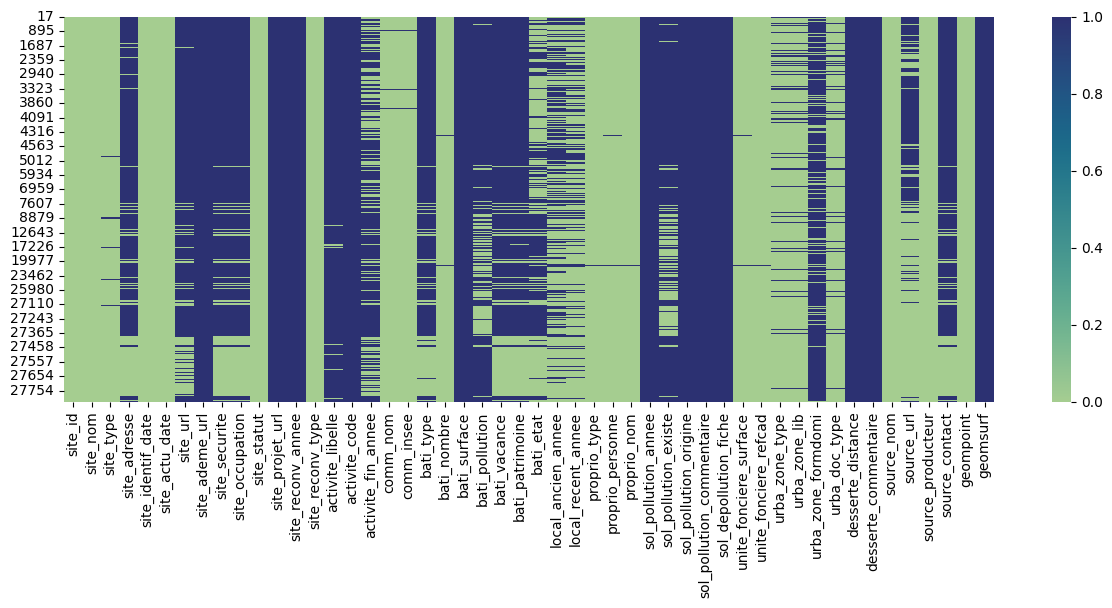

In [112]:
# Remplacer les modalités spécifiques par des NaN dans le DataFrame, pour révéler les valeurs manquantes cachées
df_friches_reconv = df_friches_reconv.replace(['inconnu', 'Inconnu', 'INCONNU', 'none', 'NULL'], pd.NA)

check_nan(df_friches_reconv)

1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "site_url" => 1939 NaNs (83.0%)
3. "bati_vacance" => 1901 NaNs (82.0%)
4. "site_securite" => 1892 NaNs (81.0%)
5. "site_occupation" => 1892 NaNs (81.0%)
6. "bati_type" => 1898 NaNs (81.0%)
7. "bati_patrimoine" => 1894 NaNs (81.0%)
8. "source_contact" => 1892 NaNs (81.0%)
9. "site_adresse" => 1849 NaNs (79.0%)
10. "bati_pollution" => 1808 NaNs (78.0%)
11. "sol_pollution_existe" => 1685 NaNs (72.0%)
12. "activite_fin_annee" => 1497 NaNs (64.0%)
13. "bati_etat" => 1102 NaNs (47.0%)
14. "source_url" => 983 NaNs (42.0%)
15. "local_ancien_annee" => 902 NaNs (39.0%)
16. "local_recent_annee" => 622 NaNs (27.0%)
17. "urba_zone_type" => 254 NaNs (11.0%)
18. "urba_zone_lib" => 254 NaNs (11.0%)
19. "urba_doc_type" => 241 NaNs (10.0%)
20. "site_type" => 43 NaNs (2.0%)
21. "comm_nom" => 23 NaNs (1.0%)
22. "comm_insee" => 23 NaNs (1.0%)
23. "bati_nombre" => 24 NaNs (1.0%)
24. "proprio_type" => 17 NaNs (1.0%)
25. "proprio_personne" => 24 NaNs (1.0%)
26. 

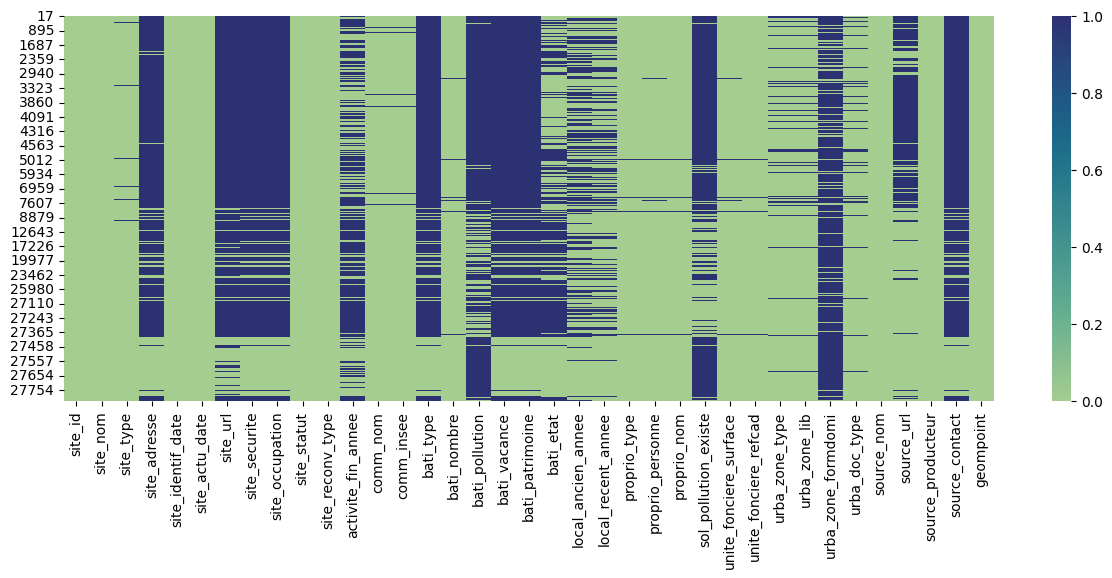

In [113]:
# Suppression des variables innexploitable (taux de valeur manquante suppérieur à 90%)
empty_values = ["site_ademe_url", "site_projet_url", "site_reconv_annee", "activite_libelle", "activite_code", "bati_surface", "sol_pollution_annee", "sol_pollution_origine", "sol_pollution_commentaire", "sol_depollution_fiche", "desserte_distance", "desserte_commentaire", "geomsurf"]

df_friches_reconv = df_friches_reconv.drop(columns=empty_values)

check_nan(df_friches_reconv)

2331 friches chargées — 22 variables
1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "bati_vacance" => 1901 NaNs (82.0%)
3. "site_securite" => 1892 NaNs (81.0%)
4. "site_occupation" => 1892 NaNs (81.0%)
5. "bati_type" => 1898 NaNs (81.0%)
6. "bati_patrimoine" => 1894 NaNs (81.0%)
7. "bati_pollution" => 1808 NaNs (78.0%)
8. "sol_pollution_existe" => 1685 NaNs (72.0%)
9. "activite_fin_annee" => 1497 NaNs (64.0%)
10. "bati_etat" => 1102 NaNs (47.0%)
11. "local_ancien_annee" => 902 NaNs (39.0%)
12. "local_recent_annee" => 622 NaNs (27.0%)
13. "urba_zone_type" => 254 NaNs (11.0%)
14. "urba_doc_type" => 241 NaNs (10.0%)
15. "site_type" => 43 NaNs (2.0%)
16. "bati_nombre" => 24 NaNs (1.0%)
17. "proprio_personne" => 24 NaNs (1.0%)
18. "unite_fonciere_surface" => 24 NaNs (1.0%)
19. "site_identif_date" => 0 NaNs (0.0%)
20. "site_actu_date" => 0 NaNs (0.0%)
21. "site_reconv_type" => 0 NaNs (0.0%)
22. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 19715


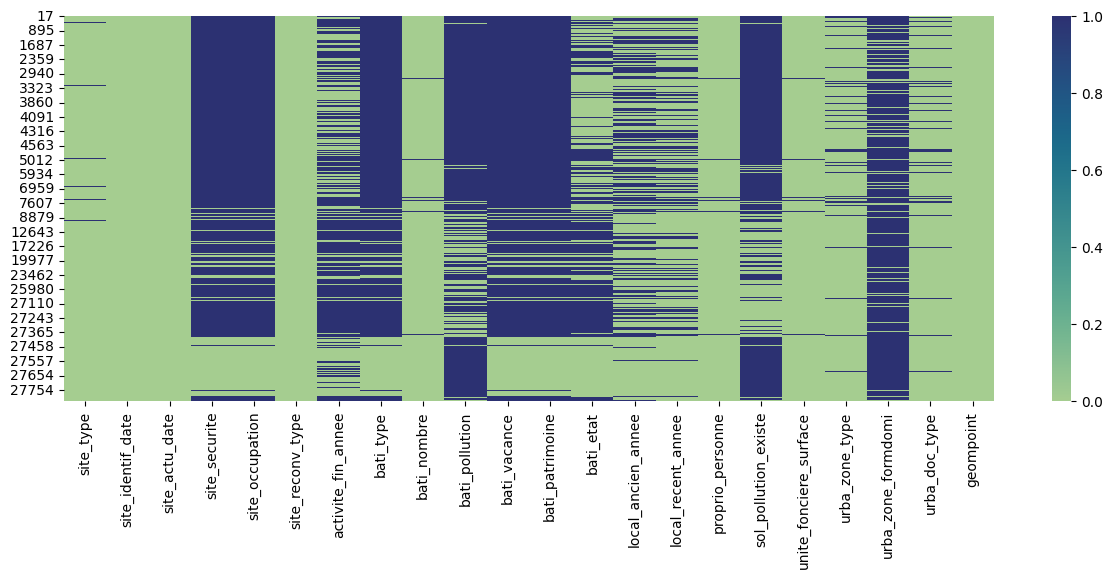

In [114]:
# Analse des variables restantes
# 1. "urba_zone_formdomi" => 2012 NaNs (86.0%) => À conserver
# 2. "site_url" => 1939 NaNs (83.0%) => Peut être supprimés car sans interêt
# 3. "bati_vacance" => 1901 NaNs (82.0%) => À conserver
# 4. "site_securite" => 1892 NaNs (81.0%) => À conserver
# 5. "site_occupation" => 1892 NaNs (81.0%) => À conserver
# 6. "bati_type" => 1898 NaNs (81.0%) => À conserver
# 7. "bati_patrimoine" => 1894 NaNs (81.0%) => À conserver
# 8. "source_contact" => 1892 NaNs (81.0%) => Peut être supprimés car sans interêt
# 9. "site_adresse" => 1849 NaNs (79.0%) => Ne peut pas être exploité ainsi, de plus nous disposons déjà de la variable "geompoint" qui présente des coordonées GPS sans valeur manquante
# 10. "bati_pollution" => 1808 NaNs (78.0%) => À conserver
# 11. "sol_pollution_existe" => 1685 NaNs (72.0%) => À conserver
# 12. "activite_fin_annee" => 1497 NaNs (64.0%) => À conserver
# 13. "bati_etat" => 1102 NaNs (47.0%) => À conserver
# 14. "source_url" => 983 NaNs (42.0%) => Peut être supprimés car sans interêt
# 15. "local_ancien_annee" => 902 NaNs (39.0%) => À conserver
# 16. "local_recent_annee" => 622 NaNs (27.0%) => À conserver
# 17. "urba_zone_type" => 254 NaNs (11.0%) => À conserver
# 18. "urba_zone_lib" => 254 NaNs (11.0%) => Peut être supprimés car redondant avec urba_zone_type
# 19. "urba_doc_type" => 241 NaNs (10.0%) => À conserver
# 20. "site_type" => 43 NaNs (2.0%) => À conserver
# 21. "comm_nom" => 23 NaNs (1.0%) => Peut être supprimés car redondant avec comm_insee
# 22. "comm_insee" => 23 NaNs (1.0%) => CF "geompoint"
# 23. "bati_nombre" => 24 NaNs (1.0%) => À conserver
# 24. "proprio_type" => 17 NaNs (1.0%) => La classification des types de propriétaires dans les fichiers fonciers, telle que "catpro3", demande à faire des expérimentations
# 25. "proprio_personne" => 24 NaNs (1.0%) => À conserver
# 26. "proprio_nom" => 17 NaNs (1.0%) => Demande à faire des expérimentations
# 27. "unite_fonciere_surface" => 24 NaNs (1.0%) => À conserver
# 28. "unite_fonciere_refcad" => 15 NaNs (1.0%) => Demande à faire des expérimentations (les identifiants de parcelles sont formatés sur 14 caractères suivant le format idpar des fichiers fonciers)
# 29. "site_id" => 0 NaNs (0.0%) => Index à supprimer
# 30. "site_nom" => 0 NaNs (0.0%) => Peut être supprimés car sans interêt
# 31. "site_identif_date" => 0 NaNs (0.0%) => À conserver
# 32. "site_actu_date" => 0 NaNs (0.0%) => À conserver
# 33. "site_statut" => 0 NaNs (0.0%) => Incohérence ici, toutes les friches ici n'affichent pas le status "friche reconvertie", à supprimer
# 34. "site_reconv_type" => 0 NaNs (0.0%) => Variable cible
# 35. "source_nom" => 0 NaNs (0.0%) => Peut être supprimés car sans interêt
# 36. "source_producteur" => 0 NaNs (0.0%) => Peut être supprimés car sans interêt
# 37. "geompoint" => 0 NaNs (0.0%) => À conserver, l'exploitation de "geompoint" serait peut-être plus pertinant, demande à faire des expérimentations

del_values = ["site_url", "source_contact", "site_adresse", "source_url", "urba_zone_lib", "comm_nom", "proprio_type", "proprio_nom", "unite_fonciere_refcad", "site_id", "site_nom", "site_statut", "source_nom", "source_producteur", "comm_insee"]
df_friches_reconv = df_friches_reconv.drop(columns=del_values)

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")

check_nan(df_friches_reconv)

# Suppression des friches sans interêt

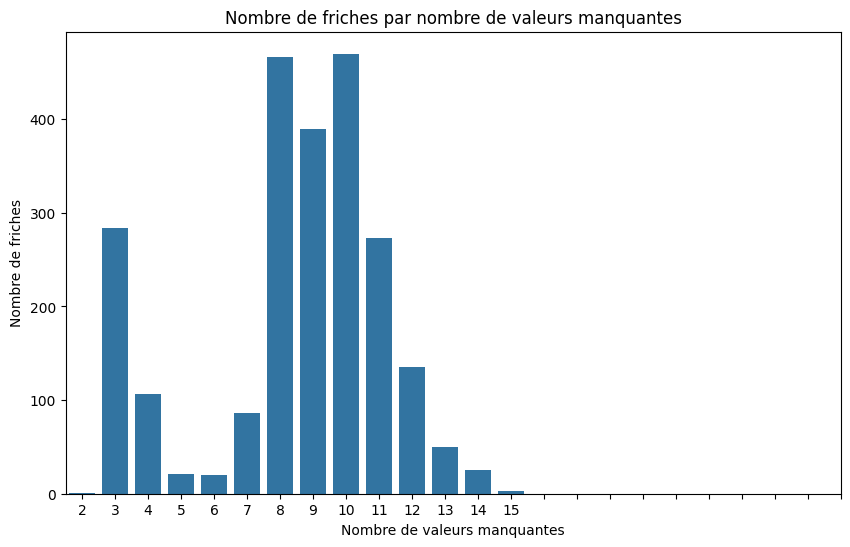

In [115]:
# Filtrer les friches sans interêts, ne possédant que très peu d'informations

friches_vides_sum = df_friches_reconv.isna().sum(axis=1)
comptes = friches_vides_sum.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=comptes.index, y=comptes.values)
plt.title('Nombre de friches par nombre de valeurs manquantes')
plt.xlabel('Nombre de valeurs manquantes')
plt.ylabel('Nombre de friches')
plt.xticks(range(0, 24))
plt.show()

In [116]:
# Fixons le seuil de tolérance à approximativement la moitité des données manquantes, soit plus de 12 informations manquantes pour considérer la friche comme étant trop "vide"
print(f"Sur les {df_friches_reconv.shape[0]} friches, {df_friches_reconv[friches_vides_sum > 12].shape[0]} friches sont sans interêt.")

Sur les 2331 friches, 78 friches sont sans interêt.


In [117]:
friches_sans_interet = df_friches_reconv[friches_vides_sum > 12].index

# Supprimer ces friches du DataFrame
df_friches_reconv = df_friches_reconv.drop(friches_sans_interet)

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")

2253 friches chargées — 22 variables


1. "urba_zone_formdomi" => 1939 NaNs (86.0%)
2. "site_securite" => 1814 NaNs (81.0%)
3. "site_occupation" => 1814 NaNs (81.0%)
4. "bati_type" => 1820 NaNs (81.0%)
5. "bati_vacance" => 1823 NaNs (81.0%)
6. "bati_patrimoine" => 1816 NaNs (81.0%)
7. "bati_pollution" => 1731 NaNs (77.0%)
8. "sol_pollution_existe" => 1616 NaNs (72.0%)
9. "activite_fin_annee" => 1429 NaNs (63.0%)
10. "bati_etat" => 1048 NaNs (47.0%)
11. "local_ancien_annee" => 825 NaNs (37.0%)
12. "local_recent_annee" => 553 NaNs (25.0%)
13. "urba_zone_type" => 205 NaNs (9.0%)
14. "urba_doc_type" => 196 NaNs (9.0%)
15. "site_type" => 33 NaNs (1.0%)
16. "site_identif_date" => 0 NaNs (0.0%)
17. "site_actu_date" => 0 NaNs (0.0%)
18. "site_reconv_type" => 0 NaNs (0.0%)
19. "bati_nombre" => 2 NaNs (0.0%)
20. "proprio_personne" => 2 NaNs (0.0%)
21. "unite_fonciere_surface" => 4 NaNs (0.0%)
22. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 18670


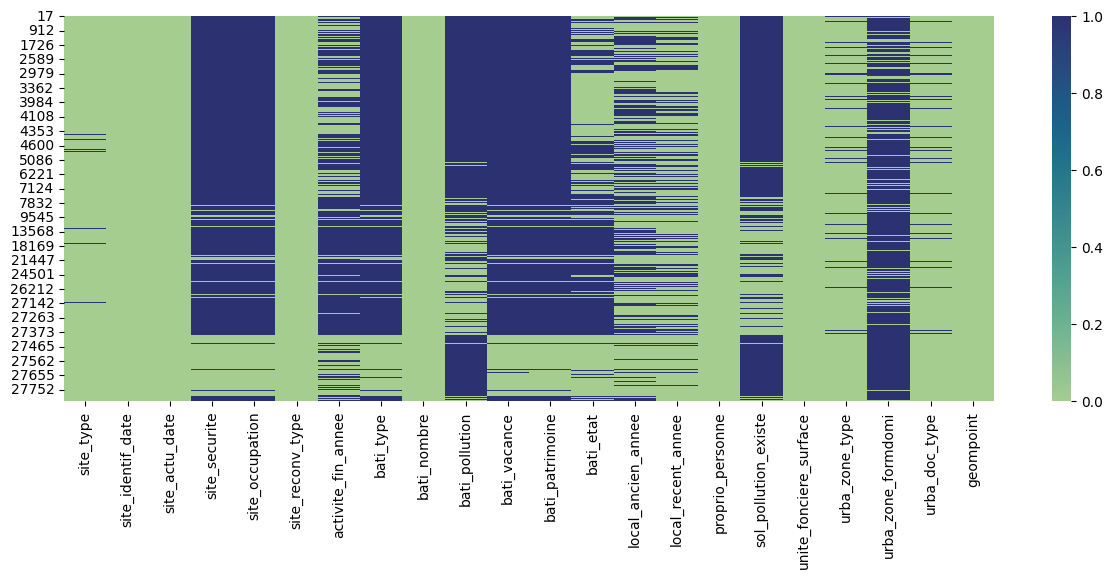

In [118]:
check_nan(df_friches_reconv)

# Suppression de bati_patrimoine

2253 friches chargées — 21 variables
1. "urba_zone_formdomi" => 1939 NaNs (86.0%)
2. "site_securite" => 1814 NaNs (81.0%)
3. "site_occupation" => 1814 NaNs (81.0%)
4. "bati_type" => 1820 NaNs (81.0%)
5. "bati_vacance" => 1823 NaNs (81.0%)
6. "bati_pollution" => 1731 NaNs (77.0%)
7. "sol_pollution_existe" => 1616 NaNs (72.0%)
8. "activite_fin_annee" => 1429 NaNs (63.0%)
9. "bati_etat" => 1048 NaNs (47.0%)
10. "local_ancien_annee" => 825 NaNs (37.0%)
11. "local_recent_annee" => 553 NaNs (25.0%)
12. "urba_zone_type" => 205 NaNs (9.0%)
13. "urba_doc_type" => 196 NaNs (9.0%)
14. "site_type" => 33 NaNs (1.0%)
15. "site_identif_date" => 0 NaNs (0.0%)
16. "site_actu_date" => 0 NaNs (0.0%)
17. "site_reconv_type" => 0 NaNs (0.0%)
18. "bati_nombre" => 2 NaNs (0.0%)
19. "proprio_personne" => 2 NaNs (0.0%)
20. "unite_fonciere_surface" => 4 NaNs (0.0%)
21. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 16854


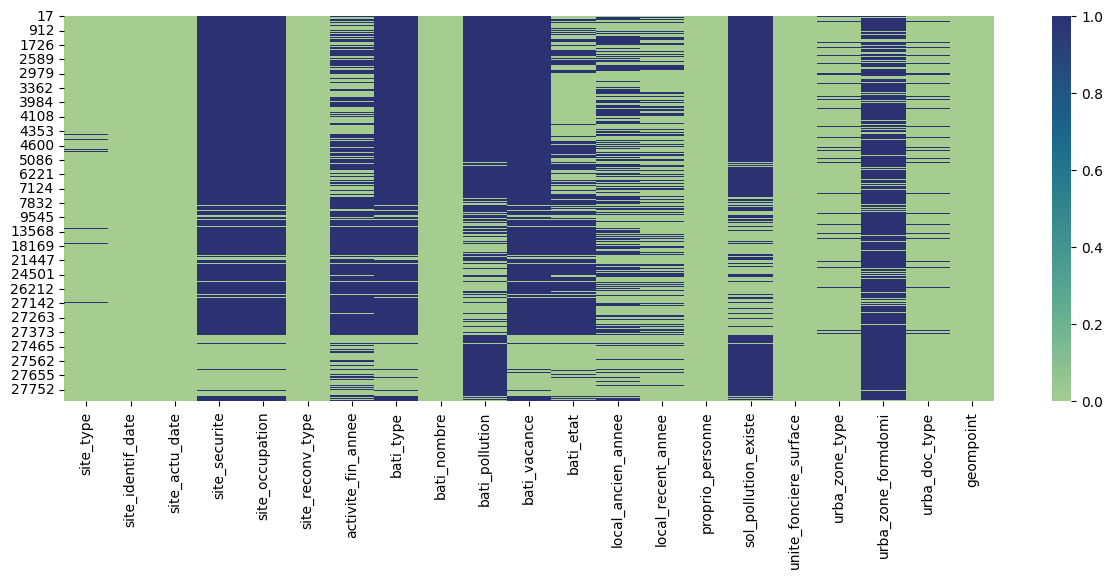

In [119]:
# Supprimer la variable bati_patrimoine du dataframe df_friches_reconv : difficilement exploitable à ce stade

df_friches_reconv = df_friches_reconv.drop(columns=['bati_patrimoine'])

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
check_nan(df_friches_reconv)

# Pré-traitement des variables

## Analyse des types

In [120]:
def dtypes_analyzer(data, qty=3):
    """
    Autor :  Heuzef (heuzef.com)
    Version : 1.0
    Description : Allows you to analyze a synthetic sample of the dataset

    Parameters
    ----------
    data : specify dataset name to analize.
    qty : quantity of the sample to display.
    """
    sample = []
    for i in data.columns:
        list_values = str(list(data[i].sample(qty)))
        sample.append(list_values)

        tab = {
            'Col': list(data.columns),
            'Dtype': list(data.dtypes),
            'Sample': sample
        }

    analize = pd.DataFrame(data=tab)
    pd.options.display.max_rows = data.shape[1]

    return(analize.style.set_properties(color="#1E90FF", align="right", **{'background-color': '#F0F8FF'}))

dtypes_analyzer(df_friches_reconv, 3)

,Col,Dtype,Sample
0,site_type,object,"[""friche d'équipement public"", ""friche d'habitat"", 'friche commerciale']"
1,site_identif_date,object,"['2018-09-25', '2024-06-18', '2019-12-31']"
2,site_actu_date,object,"['2024-08-27', '2024-02-13', '2024-01-11']"
3,site_securite,object,"['évacuation des produits dangereux et déchets présents sur le site', 'évacuation des produits dangereux et déchets présents sur le site', 'évacuation des produits dangereux et déchets présents sur le site']"
4,site_occupation,object,"[, , ]"
5,site_reconv_type,object,"['renaturation', ""aménagement d'espace public"", 'mixte']"
6,activite_fin_annee,object,"['2018', '2000', nan]"
7,bati_type,object,"['résidentiel', , ]"
8,bati_nombre,float64,"[2.0, 4.0, 0.0]"
9,bati_pollution,object,"[, , 'amiante']"


In [121]:
pd.reset_option("display.max_rows")

# Conclusion de l'analyse et transformation à appliquer :

# site_identif_date => À convertir en Datetime
# site_actu_date => À convertir en Datetime
# activite_fin_annee => À convertir en Datetime
# bati_nombre => À convertir en INT
# local_ancien_annee => À convertir en Datetime
# local_recent_annee => À convertir en Datetime
# unite_fonciere_surface => À convertir en INT
# geompoint => Créer deux variables float latitude + longitude

# Toutes les autres variables object doivent être encodées et converties en numérique

## Suppression des champs date

2253 friches chargées — 16 variables
1. "urba_zone_formdomi" => 1939 NaNs (86.0%)
2. "site_securite" => 1814 NaNs (81.0%)
3. "site_occupation" => 1814 NaNs (81.0%)
4. "bati_type" => 1820 NaNs (81.0%)
5. "bati_vacance" => 1823 NaNs (81.0%)
6. "bati_pollution" => 1731 NaNs (77.0%)
7. "sol_pollution_existe" => 1616 NaNs (72.0%)
8. "bati_etat" => 1048 NaNs (47.0%)
9. "urba_zone_type" => 205 NaNs (9.0%)
10. "urba_doc_type" => 196 NaNs (9.0%)
11. "site_type" => 33 NaNs (1.0%)
12. "site_reconv_type" => 0 NaNs (0.0%)
13. "bati_nombre" => 2 NaNs (0.0%)
14. "proprio_personne" => 2 NaNs (0.0%)
15. "unite_fonciere_surface" => 4 NaNs (0.0%)
16. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 14047


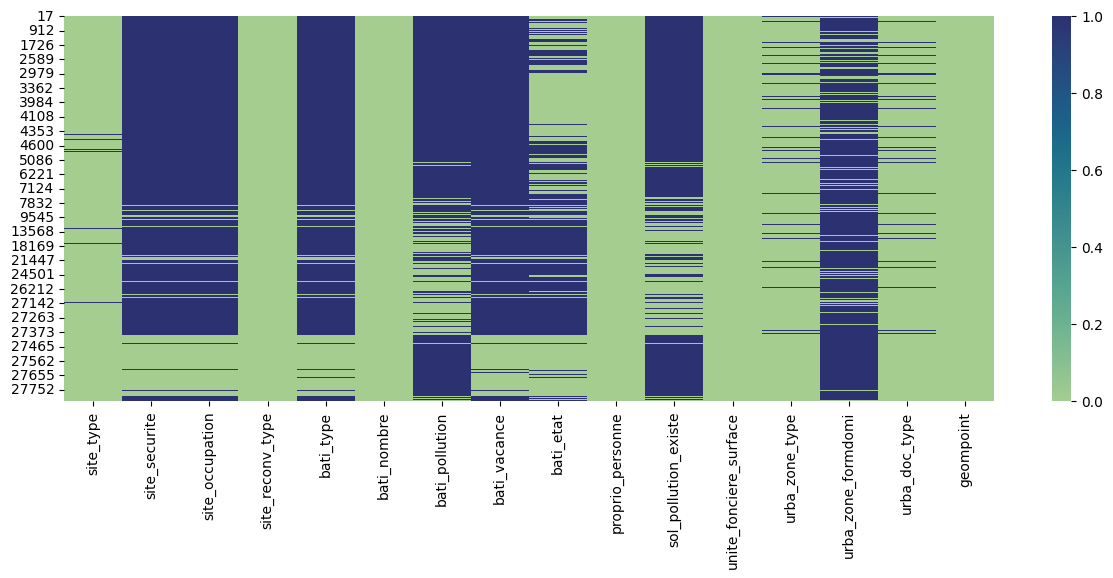

In [122]:
# Les variable dates ne sont pas correctement formatée et standardisé, un travail de nettoyage conséquent est nécessaire
df_friches_reconv = df_friches_reconv.drop(columns=['site_identif_date', 'site_actu_date', 'activite_fin_annee', 'local_ancien_annee', 'local_recent_annee'])

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
check_nan(df_friches_reconv)

# bati_nombre

In [123]:
# ...

# unite_fonciere_surface

In [124]:
# ...

## geompoint

1. "urba_zone_formdomi" => 1939 NaNs (86.0%)
2. "site_securite" => 1814 NaNs (81.0%)
3. "site_occupation" => 1814 NaNs (81.0%)
4. "bati_type" => 1820 NaNs (81.0%)
5. "bati_vacance" => 1823 NaNs (81.0%)
6. "bati_pollution" => 1731 NaNs (77.0%)
7. "sol_pollution_existe" => 1616 NaNs (72.0%)
8. "bati_etat" => 1048 NaNs (47.0%)
9. "longitude" => 526 NaNs (23.0%)
10. "latitude" => 526 NaNs (23.0%)
11. "urba_zone_type" => 205 NaNs (9.0%)
12. "urba_doc_type" => 196 NaNs (9.0%)
13. "site_type" => 33 NaNs (1.0%)
14. "site_reconv_type" => 0 NaNs (0.0%)
15. "bati_nombre" => 2 NaNs (0.0%)
16. "proprio_personne" => 2 NaNs (0.0%)
17. "unite_fonciere_surface" => 4 NaNs (0.0%)

Total NaNs : 15099


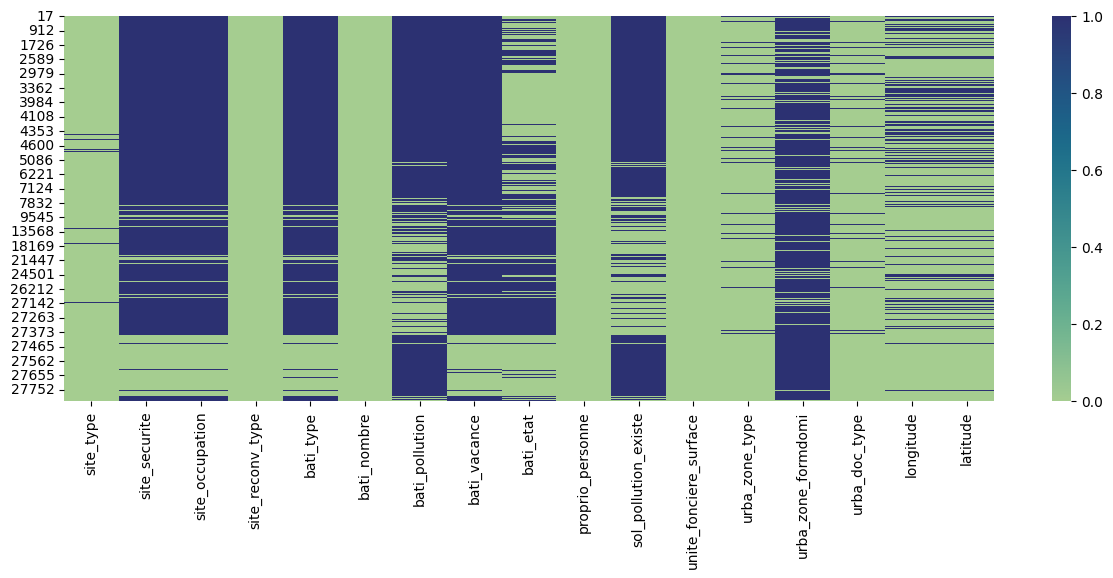

In [125]:
# Fonction pour extraire les coordonnées
def extract_coordinates(wkt_point):
    match = re.match(r'POINT \(([\d.]+) ([\d.]+)\)', wkt_point)
    if match:
        longitude, latitude = match.groups()
        return pd.Series({'longitude': float(longitude), 'latitude': float(latitude)})
    return pd.Series({'longitude': None, 'latitude': None})

# Appliquer la fonction pour créer de nouvelles variable
df_friches_reconv[['longitude', 'latitude']] = df_friches_reconv['geompoint'].apply(extract_coordinates)

# Supprimer geompoint
df_friches_reconv = df_friches_reconv.drop(columns=['geompoint'])

check_nan(df_friches_reconv)

## urba_zone_formdomi

1. "site_securite" => 1814 NaNs (81.0%)
2. "site_occupation" => 1814 NaNs (81.0%)
3. "bati_type" => 1820 NaNs (81.0%)
4. "bati_vacance" => 1823 NaNs (81.0%)
5. "bati_pollution" => 1731 NaNs (77.0%)
6. "sol_pollution_existe" => 1616 NaNs (72.0%)
7. "bati_etat" => 1048 NaNs (47.0%)
8. "longitude" => 526 NaNs (23.0%)
9. "latitude" => 526 NaNs (23.0%)
10. "urba_zone_type" => 205 NaNs (9.0%)
11. "urba_doc_type" => 196 NaNs (9.0%)
12. "site_type" => 33 NaNs (1.0%)
13. "site_reconv_type" => 0 NaNs (0.0%)
14. "bati_nombre" => 2 NaNs (0.0%)
15. "proprio_personne" => 2 NaNs (0.0%)
16. "unite_fonciere_surface" => 4 NaNs (0.0%)
17. "urba_zone_formdomi" => 0 NaNs (0.0%)

Total NaNs : 13160


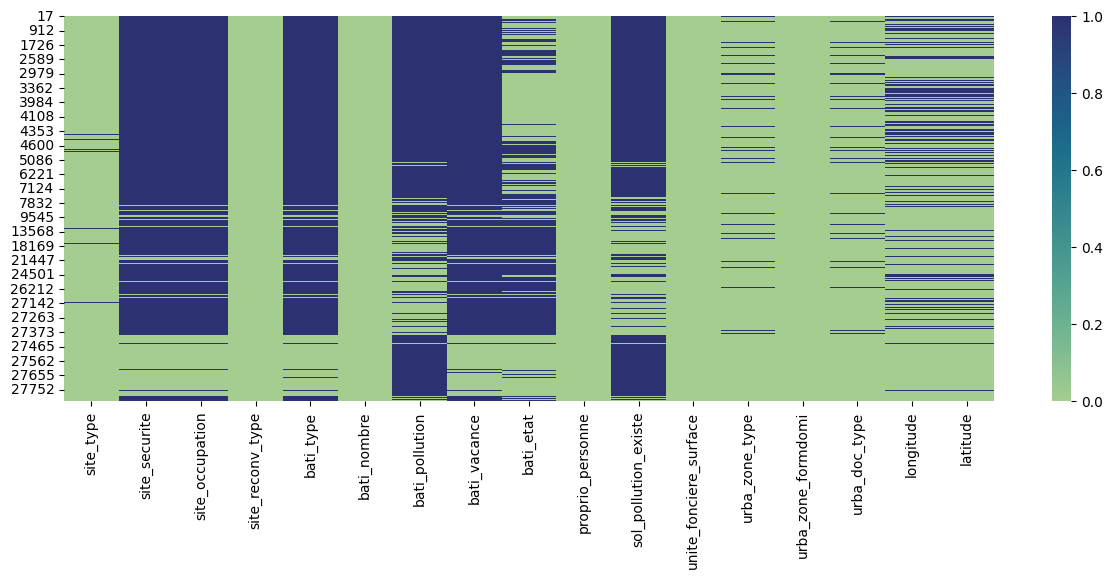

In [142]:
# Remplacement des NaN par une one urbaine de type "Autre"
df_friches_reconv["urba_zone_formdomi"] = df_friches_reconv["urba_zone_formdomi"].fillna("Autres")

check_nan(df_friches_reconv)

## site_securite

In [157]:
df_friches_reconv["site_securite"].unique()

array([<NA>, nan,
       'évacuation des produits dangereux et déchets présents sur le site'],
      dtype=object)

In [ ]:
# Determiner et encoder si la friche est assurément sécurisée
df_friches_reconv["site_securite"] = df_friches_reconv["site_securite"].replace('évacuation des produits dangereux et déchets présents sur le site', '1')
df_friches_reconv["site_securite"] = df_friches_reconv["site_securite"].fillna("0")

df_friches_reconv["site_securite"].unique()

array(['0', '1'], dtype=object)

1. "site_occupation" => 1814 NaNs (81.0%)
2. "bati_type" => 1820 NaNs (81.0%)
3. "bati_vacance" => 1823 NaNs (81.0%)
4. "bati_pollution" => 1731 NaNs (77.0%)
5. "sol_pollution_existe" => 1616 NaNs (72.0%)
6. "bati_etat" => 1048 NaNs (47.0%)
7. "longitude" => 526 NaNs (23.0%)
8. "latitude" => 526 NaNs (23.0%)
9. "urba_zone_type" => 205 NaNs (9.0%)
10. "urba_doc_type" => 196 NaNs (9.0%)
11. "site_type" => 33 NaNs (1.0%)
12. "site_securite" => 0 NaNs (0.0%)
13. "site_reconv_type" => 0 NaNs (0.0%)
14. "bati_nombre" => 2 NaNs (0.0%)
15. "proprio_personne" => 2 NaNs (0.0%)
16. "unite_fonciere_surface" => 4 NaNs (0.0%)
17. "urba_zone_formdomi" => 0 NaNs (0.0%)

Total NaNs : 11346


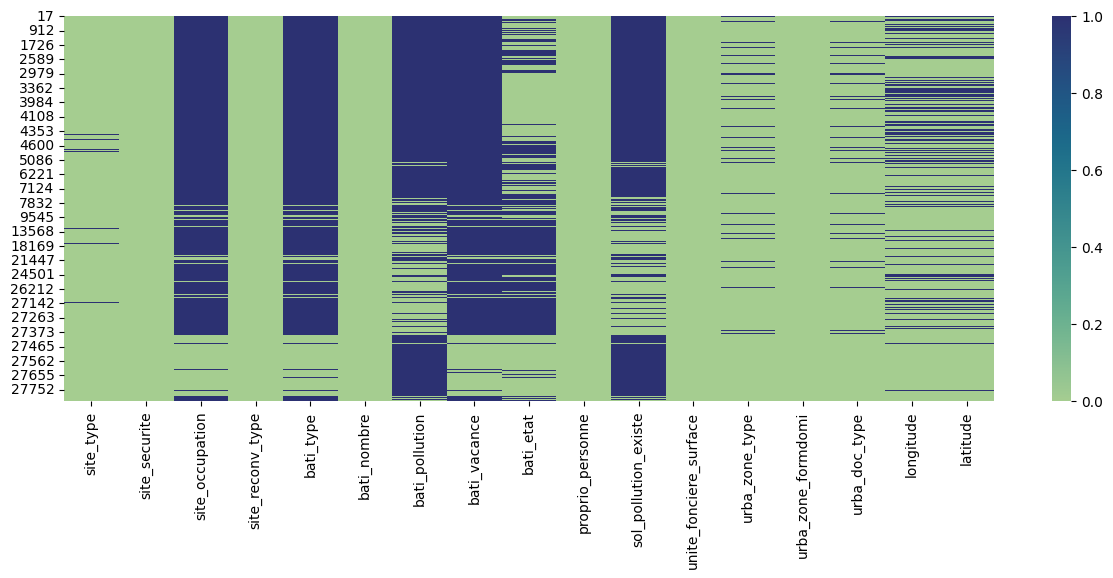

In [159]:
check_nan(df_friches_reconv)

## site_occupation

In [128]:
# ...

## bati_type

In [129]:
# ...

## bati_vacance

In [130]:
# ...

## bati_pollution

In [131]:
# ...

## sol_pollution_existe

In [132]:
# ...

## bati_etat

In [133]:
# ...

## urba_zone_type

In [134]:
# ...

## urba_doc_type

In [135]:
# ...

## site_type

In [136]:
# ...

## proprio_personne

In [137]:
# ...

# Export des données pour l'entrainement

In [163]:
df_friches_reconv.to_csv('./data/friches_silver.csv', index=False)